In [218]:
import os
import json
import re
import ast
import json
from graphviz import Digraph
import pandas as pd

# color the graph
import graph_tool.all as gt
import copy
import matplotlib.colors as mcolors
import sys
import matplotlib.colors as mcolors



import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import os
import json
import itertools
import matplotlib
import matplotlib.ticker as ticker

worker_color = {'10.255.23.108': '#e41a1c',
    '10.255.23.109': '#984ea3',
    '10.255.23.110': '#ff7f00',
    '10.255.23.115': '#4daf4a'}

results_dir = '/local0/serverless/evaluation/plots'
stats_dir='/opt/dask-distributed/benchmark/stats'

In [261]:
# get all benchmarks
def get_benchmarks():
    benchmarks = {}
    for _file in os.listdir(stats_dir):
        try:
            app = _file.split('.', 1)[0]
            assert os.path.isfile(os.path.join(stats_dir, f'{app}.g')) \
                    and os.path.isfile(os.path.join(stats_dir, f'{app}.json')) \
                    and os.path.isfile(os.path.join(stats_dir, f'{app}.colors'))

            bnch, scheduler, _ =  app.split('_', 2)
            #scheduler = 'vanilla'
            
            benchmarks[app] = {'app': app, 'scheduler': scheduler, 'benchmark': bnch}
        except AssertionError:
            pass
    return benchmarks



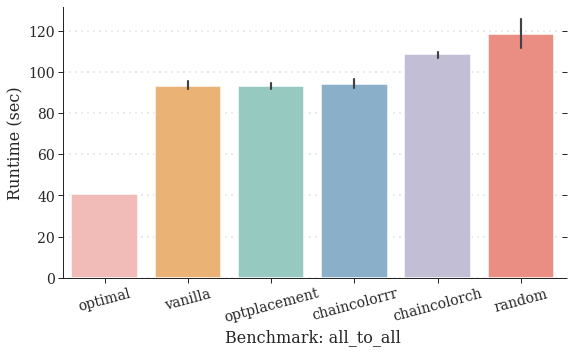

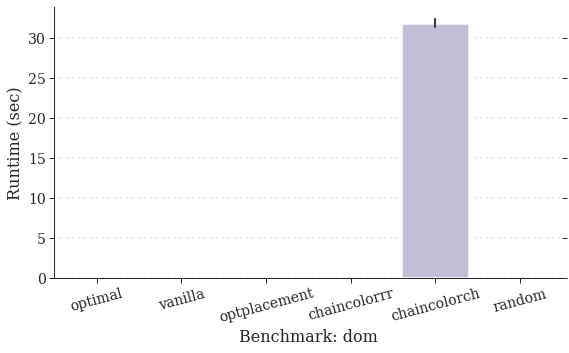

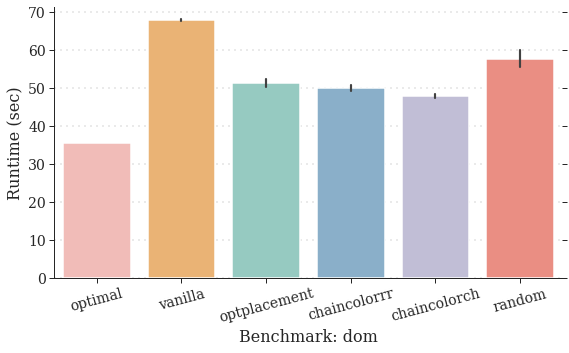

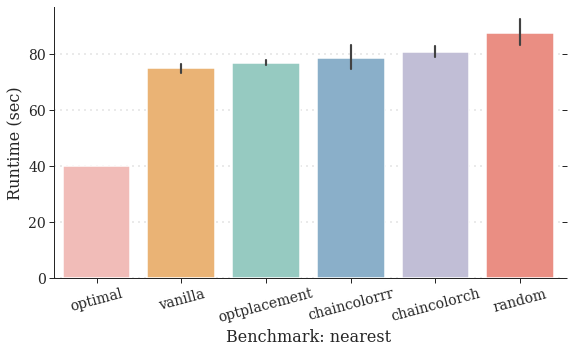

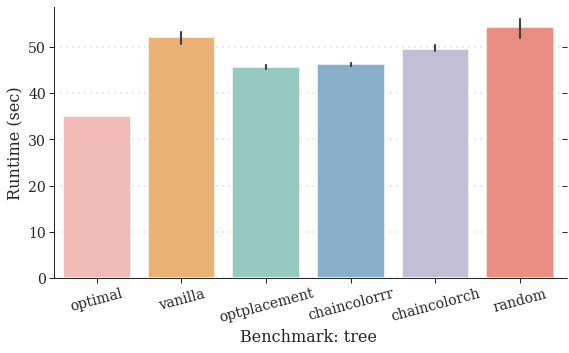

In [290]:

worker_color = {'10.255.23.108': '#e41a1c',
    '10.255.23.109': '#984ea3',
    '10.255.23.110': '#ff7f00',
    '10.255.23.115': '#4daf4a'}


    
def color_assignment(benchmark, task_style):
    cfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.colors'
    with open(cfile, 'r') as cfd:
        raw = cfd.read().split('\n')
        for ln in raw:
            if not ln: 
                continue
            task_name, actual = ln.split(',')
            if task_name not in task_style:
                task_style[task_name] = {}
            task_style[task_name]['actual'] = actual
    
    
def build_graph(benchmark, task_style):
    css_colors = list(mcolors.CSS4_COLORS.keys())
    gfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.g'

    with open(gfile, 'r') as fd:
        raw = fd.read().split('\n')
        g = gt.Graph(directed=True)
        vid_to_vx = {}
        name_to_vid = {}

        g.vertex_properties['name'] = g.new_vertex_property("string")
        g.vertex_properties['color'] = g.new_vertex_property("string")
        g.vertex_properties['worker'] = g.new_vertex_property("string")
        g.vertex_properties['icolor'] = g.new_vertex_property("int")
        g.vertex_properties['simcolor'] = g.new_vertex_property("string")
        g.vertex_properties['isimcolor'] = g.new_vertex_property("string")
        for ln in raw:
            if ln.startswith('v'):
                _, vid, name = ln.split(',', 2)
                v = g.add_vertex()
                vid_to_vx[vid] = v
                name_to_vid[name] = vid

                g.vp.name[v] = name
                try:
                    g.vp.icolor[v] = int(task_style[name]['actual'])
                    #if g.vp.icolor[v] >= len(css_colors):
                    #g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[0]]
                    #else:
                    g.vp.color[v] = mcolors.CSS4_COLORS[css_colors[int(task_style[name]['actual'])]]
                except KeyError:
                    print(f'Keyerror for {name}')
                    raise NameError('Error')
                    #g.vp.color[v] = 'yellow'
                    #g.vp.icolor[v] = 2

        for ln in raw:        
            if ln.startswith('e'):
                _, vsrc, vdst, _ = ln.split(',', 3)
                g.add_edge(vid_to_vx[vsrc], vid_to_vx[vdst])
    return g
          
keys = list(mcolors.CSS4_COLORS.keys())
def update_runtime_state(benchmark, g, task_style):
    print('process', benchmark)
    tasks = []
    jfile = f'/opt/dask-distributed/benchmark/stats/{benchmark}.json'
    with open(jfile, 'r') as fd:
        stats = ast.literal_eval(fd.read())

        #print(json.dumps(stats, indent=4))
        print('stat size is', len(stats))
        
        min_ts = sys.maxsize
        for s in stats:
            task_style[s]['output_size'] = stats[s]['msg']['nbytes']
            task_style[s]['input_size'] = 0
            task_style[s]['remote_read'] = 0
            task_style[s]['local_read'] = 0
            task_style[s]['worker'] = stats[s]['worker'].split(':')[1].replace('/', '')
            
            startsstops = stats[s]['msg']['startstops']
            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['action'] == 'compute':
                    task_style[s]['compute_end'] = ss['stop']
                    task_style[s]['compute_start'] = ss['start']
                    task_style[s]['runtime'] = ss['stop'] - ss['start']
                if ss['start'] < min_ts:  min_ts = ss['start']
                if ss['stop'] < min_ts:  min_ts = ss['stop']
                    
        print(min_ts)
        for s in stats:
            startsstops = stats[s]['msg']['startstops']
            min_start = sys.maxsize
            max_end = 0

            transfer_stop = 0
            transfer_start = sys.maxsize
            for ss in startsstops:
                if ss['action'] == 'inputsize': continue
                if ss['start'] < min_start:  min_start = ss['start']
                if ss['stop'] > max_end:  max_end = ss['stop']
                
                if ss['action'] == 'compute':
                    compute_stop = ss['stop']
                    compute_start = ss['start']
                    run_time = ss['stop'] - ss['start']
                
                if ss['action'] == 'transfer':
                    #print(ss['start'] - min_ts, ss['stop'] - min_ts)
                    if ss['start'] < transfer_start:
                       transfer_start = ss['start']
                    if ss['stop'] > transfer_stop:
                        transfer_stop = ss['stop']
                    #print('transfer start', ss['start'] - min_ts, 
                    #      'transfer stop', ss['stop'] - min_ts)
                    
            
            if transfer_stop == 0: 
                transfer_stop = compute_start
                transfer_start = compute_start
            #print('***transfer start', transfer_start - min_ts, 
            #              '****transfer stop', transfer_stop - min_ts)
            tasks.append({'name': s, 'start_ts': min_start - min_ts, 'end_ts': max_end - min_ts, 
                          'compute_start': compute_start - min_ts, 'compute_stop': compute_stop - min_ts,
                          'transfer_start': transfer_start - min_ts, 'transfer_stop': transfer_stop - min_ts,
                          'worker': stats[s]['worker'].split(':')[1].replace('/', '')})
            #print('\n')
            
    
    
        #total amount of data accessed, data accessed remotely, data accessed locally
        for v in g.vertices():
            for vi in v.in_neighbors():
                task_style[g.vp.name[v]]['input_size'] += task_style[g.vp.name[vi]]['output_size']
                if task_style[g.vp.name[v]]['worker'] == task_style[g.vp.name[vi]]['worker']:
                    task_style[g.vp.name[v]]['local_read'] += task_style[g.vp.name[vi]]['output_size']
                else:
                    task_style[g.vp.name[v]]['remote_read'] += task_style[g.vp.name[vi]]['output_size']
                  
        for v in g.vertices():
            g.vp.worker[v] = task_style[g.vp.name[v]]['worker']
            #g.vp.color[v] = colors[task_style[g.vp.name[v]]['worker']]
            
        #Check the slack for the prefetching
        bw = 10*(1<<27) # 10 Gbps (1<<30)/(1<<3)
        not_from_remote = 0
        for v in g.vertices():
            parents_end = []
            for vi in v.in_neighbors():
                parents_end.append(task_style[g.vp.name[vi]]['compute_end'])
                
            if len(parents_end):
                max_end = max(parents_end)
                
                for vi in v.in_neighbors():
                    if max_end == task_style[g.vp.name[vi]]['compute_end'] and task_style[g.vp.name[vi]]['worker'] != task_style[g.vp.name[v]]['worker']:
                        #print(f'Slack come from local chain')
                        not_from_remote += 1
            

                #print(f'slack for {g.vp.name[v]}: {round(1000*(max(parents_end) - min(parents_end)), 2)}msec',
                #     '\t runtime:', round(1000*task_style[g.vp.name[vi]]['runtime'], 4), 'msec',
                #     '\t remote read', task_style[g.vp.name[v]]['remote_read']/bw)
        #print(not_from_remote)
        return tasks



def plot_graph(g):
    policy = b.split('_')[1]
    print('policy is', policy)
    dg = Digraph('G', filename=f'{b}.gv', format='png')
    for v in g.vertices():
        #print(g.vp.name[v])
        
        vname = g.vp.name[v].split('-', 1)
        vname = vname[1] if len(vname) > 1 else vname[0]
        
        
        #dg.attr('node', shape='ellipse', style='filled', color=g.vp.color[v])
        dg.attr('node', shape='ellipse', style="filled,solid",
                penwidth="3",
                fillcolor=g.vp.color[v] if "chaincolor" in policy else "#f0f0f0",
                color=worker_color[g.vp.worker[v]])
        
        color = '-'
        if 'chaincolor' in policy:
            color = g.vp.icolor[v]
        dg.node(f'{vname}, color({color})')
        #print(g.vp.name[v], g.vp.icolor[v], g.vp.worker[v])
    for e in g.edges():
        vname = g.vp.name[e.source()].split('-', 1)
        sname = vname[1] if len(vname) > 1 else vname[0]
        
        vname = g.vp.name[e.target()].split('-', 1)
        tname = vname[1] if len(vname) > 1 else vname[0]
        
        dg.edge(f'{sname}, color({g.vp.icolor[e.source()] if "chaincolor" in policy else "-"})', 
                f'{tname}, color({g.vp.icolor[e.target()] if "chaincolor" in policy else "-"})')
    dg.view(f'/local0/serverless/serverless-sim/results/{b}', quiet=False)

    
def plot_graph2(g):
    policy = b.split('_')[1]
    dg = Digraph('G', filename=f'{b.split("_")[0]}.gv', format='png')
    for v in g.vertices():
        vname = g.vp.name[v].split('-', 1)
        vname = vname[1] if len(vname) > 1 else vname[0]
        
        dg.attr('node', shape='ellipse', style='filled', color='#252525')
        dg.attr('node', shape='ellipse', style="filled,solid",
                penwidth="3",
                fillcolor= "#f0f0f0",
                color='#252525')
        
        dg.node(f'{vname}')
    for e in g.edges():
        vname = g.vp.name[e.source()].split('-', 1)
        sname = vname[1] if len(vname) > 1 else vname[0]
        
        vname = g.vp.name[e.target()].split('-', 1)
        tname = vname[1] if len(vname) > 1 else vname[0]
        
        dg.edge(f'{sname}', 
                f'{tname}')

    dg.view(f'/local0/serverless/serverless-sim/results/{b.split("_")[0]}', quiet=False)

    

def format_xticks(x, pos=None):
    return x
    #return str(int(x*1000))
    
def plot_gannt_chart(tasks, benchmark):
    _max = df['runtime'].max()
    print(benchmark, df['runtime'].max())
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

    plt.rc('font', family='serif')

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('Time (second)', fontsize=16)

    sns.despine()
    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

    ax.set_axisbelow(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks))
    ax.set_yticklabels([])
    ax.set_xlim([0, _max])

    # Setting graph attribute
    ax.grid(True)
    
    
    base = 0
    size = 8
    margin = 3
    workers_load={}
    for ts in tasks:
        #print(json.dumps(ts, indent=4))
        #print(ts['name'], ts['start_ts'], ts['end_ts'], ts['worker'])
        if ts['worker'] not in workers_load:
            workers_load[ts['worker']] = []
        #workers_load[ts['worker']].append((ts['start_ts'], ts['end_ts'] - ts['start_ts']))
        ax.broken_barh([(ts['transfer_start'], ts['transfer_stop'] - ts['transfer_start'])], (base, size), 
                       edgecolors =worker_color[ts['worker']], facecolors = worker_color[ts['worker']])
        ax.broken_barh([(ts['compute_start'], ts['compute_stop'] - ts['compute_start'])], (base, size), 
                       edgecolors = worker_color[ts['worker']], facecolors='#f0f0f0')
        
        vname = ts['name'].split('-', 1)
        sname = vname[1] if len(vname) > 1 else vname[0]
        
        ax.text(x=ts['compute_start'] + (ts['compute_stop'] - ts['compute_start'])/2, 
                y=base + size/2,
                s=sname, 
                ha='center', 
                va='center',
                color='black')
        
        base += (size + margin)
    jobname, policy, _ = benchmark.split('_')
    #ax.axes.yaxis.set_visible(False)
    ax.set_ylabel(f'{benchmark}', fontsize=14)
    ax.set_title(f'{jobname}, {policy}', fontsize=16)
    leg1 = ax.legend(['10.255.23.108', '10.255.23.109', '10.255.23.109', '10.255.23.115'], 
              title='Communication cost', ncol = 1, loc='lower center')
    leg1.legendHandles[0].set_color(worker_color['10.255.23.108'])
    leg1.legendHandles[1].set_color(worker_color['10.255.23.109'])
    leg1.legendHandles[2].set_color(worker_color['10.255.23.110'])
    leg1.legendHandles[3].set_color(worker_color['10.255.23.115'])

    leg2 = ax.legend(['10.255.23.108', '10.255.23.109', '10.255.23.109', '10.255.23.115'], 
              title='Computation cost',loc='lower right')
    leg2.legendHandles[0].set_edgecolor(worker_color['10.255.23.108'])
    leg2.legendHandles[1].set_edgecolor(worker_color['10.255.23.109'])
    leg2.legendHandles[2].set_edgecolor(worker_color['10.255.23.110'])
    leg2.legendHandles[3].set_edgecolor(worker_color['10.255.23.115'])
    leg2.legendHandles[0].set_facecolor('#f0f0f0')
    leg2.legendHandles[1].set_facecolor('#f0f0f0')
    leg2.legendHandles[2].set_facecolor('#f0f0f0')
    leg2.legendHandles[3].set_facecolor('#f0f0f0')
    
    end_2_end = df[df['exp'] == benchmark]['runtime']
    ax.vlines(end_2_end, ymin=0, ymax=base, label = end_2_end, linestyles='--', color='#bdbdbd')
    
    ax.add_artist(leg1)
    fig.savefig(f'{os.path.join("/local0/serverless/serverless-sim/results",benchmark)}.gannt.png', 
                format='png', dpi=200)
    plt.show()

def plot_runtime(name, df):
    sns.set_style("ticks")
        
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})

    plt.rc('font', family='serif')

    fig, ax = plt.subplots(figsize=(8,5))
    sns.barplot(x='scheduler', y='runtime', #, hue = 'scheduler', 
                order = ['optimal', 'vanilla', 'optplacement', 'chaincolorrr', 'chaincolorch', 'random'],
                palette = ['#fbb4ae','#fdb462', '#8dd3c7', '#80b1d3', '#bebada' , '#fb8072'],
                data=df, ax=ax)
    sns.despine()

    ax.yaxis.grid(color='#99999910', linestyle=(0, (5, 10)), linewidth=0.4)

    ax.set_axisbelow(True)
    ax.tick_params(axis='x', which='major', labelsize=14, rotation=15)
    ax.tick_params(axis='y', which='major', labelsize=14)
    ax.yaxis.set_ticks_position('both')
    
    ax.set_ylabel('Runtime (sec)', fontsize=16)
    ax.set_xlabel(f'Benchmark: {df["benchmark"].unique()[0]}', fontsize=16)
    #ax.legend(fontsize=14, ncol=3)

    plt.tight_layout()
    fig.savefig(f'/local0/serverless/serverless-sim/results/runtime_{name}.png', 
                    format='png', dpi=200)
    plt.show()


dt = pd.read_csv('/local0/serverless/task-bench/dask/stats.csv')
dt.head(5)

gdf = dt.groupby('name')
benchmarks = get_benchmarks()

for name, df in gdf:
    plot_runtime(name, df)
    continue
    #if 'spread' not in name: continue
    for b in benchmarks:
        if name not in b: continue    
        task_style = {}
        color_assignment(b, task_style)
        g = build_graph(b, task_style)
        tasks = update_runtime_state(b, g, task_style)
        plot_graph(g)
        plot_graph2(g)
        plot_gannt_chart(tasks, b)
        #break
    #break

In [288]:
dt[(dt['benchmark'] == 'dom')]

,exp,name,scheduler,benchmark,height,width,runtime
26,dom4x61GB1B_chaincolorch_0bee9b47,dom4x61GB1B,chaincolorch,dom,4,6,48.866190
27,dom4x61GB1B_chaincolorch_297c9516,dom4x61GB1B,chaincolorch,dom,4,6,47.999270
28,dom4x61GB1B_chaincolorch_469f7fa3,dom4x61GB1B,chaincolorch,dom,4,6,48.008930
29,dom4x61GB1B_chaincolorch_63ad9cba,dom4x61GB1B,chaincolorch,dom,4,6,47.093210
30,dom4x61GB1B_chaincolorch_8039475f,dom4x61GB1B,chaincolorch,dom,4,6,47.875100
31,dom4x61GB1B_chaincolorrr_72c520b4,dom4x61GB1B,chaincolorrr,dom,4,6,51.325270
32,dom4x61GB1B_chaincolorrr_91c8d763,dom4x61GB1B,chaincolorrr,dom,4,6,50.277050
33,dom4x61GB1B_chaincolorrr_b02b73b7,dom4x61GB1B,chaincolorrr,dom,4,6,49.710440
34,dom4x61GB1B_chaincolorrr_ce41792f,dom4x61GB1B,chaincolorrr,dom,4,6,49.352960
35,dom4x61GB1B_chaincolorrr_ec1afcb8,dom4x61GB1B,chaincolorrr,dom,4,6,48.651630


In [ ]:
dt[(dt['benchmark'] == 'dom') & (dt['scheduler'] == 'chaincolor')]